# ASTR597 -- Homework 1
Kolby Weisenburger

2 February 2016

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import sqlite3
from astropy.table import Table
import pandas as pd
import os 

plt.rcParams.update({'font.size': 30})

%matplotlib inline

## Problem 1: Querying and data analysis with SDSS


* Write (and execute) an SQL query to count how many stars have been observed with SDSS (in the current Data Release 12).

<b>There are 260,562,744 rows in the Star catalog.</b>


* Write (and execute) an SQL query to count how many observations there are in $u, g, r, i$ and $z$ bands, and the average observed magnitude in each band. How does the SDSS database record missing (magnitude) data?


<b>#, average $u$ mag:</b>    260561128,	23.33

<b>#, average $g$ mag:</b>    260560429,	22.22

<b>#, average $r$ mag:</b>    260561511,	21.13

<b>#, average $i$ mag:</b>    260560369,	20.41

<b>#, average $z$ mag:</b>    260561329,	19.88

<b>SDSS records missing magnitude values as -9999.</b>

* Write an SQL query to select the positions and the extinction-corrected (a.k.a. dereddened) $g$ and $r$-band magnitudes of all stars bounded by $225 < \alpha < 235$ and $-2.5 < \delta < 4$. Your query should store the outputs into a temporary table in MyDB. Download it as a FITS file. Use the `astropy.tables` module to load the table data into Python, then store it into a local sqlite database (using `Pandas` to_sql() functions).

In [68]:
# load SQL results into a dataframe then 
# use pandas to store in local sqlite db
# note: delete field.db if already exists

field1 = Table.read('part2_kolbylyn.fit')
df = field1.to_pandas()

try:
    os.remove('field.db')
except OSError:
    pass
db = sqlite3.connect('field.db')
df.to_sql('field',db)

* In an IPython notebook, make an ra vs dec scatter plot of the data. Note that the right ascension by convention increases from right to left; make sure your plot reflects that. What do you see near $\alpha \sim$ 229 and $\delta \sim$ 0? Do know what is this object?

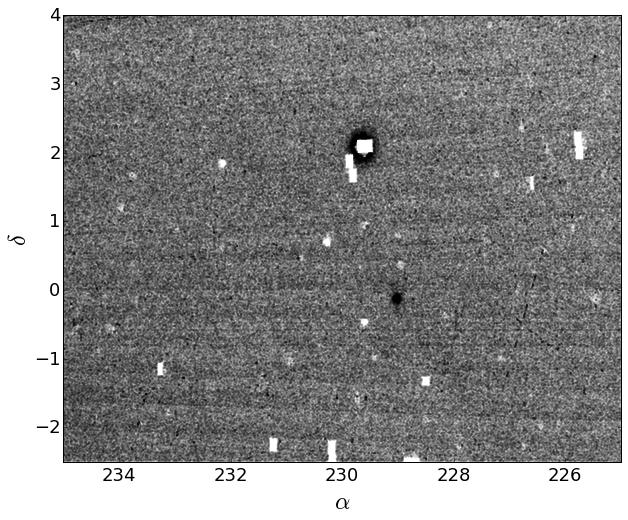

In [69]:
plt.figure(figsize=(10,8))
plt.scatter(df['ra'], df['dec'],s=.005,alpha=.8,color='k')
plt.xlim(235, 225)
plt.ylim(-2.5,4)
plt.xlabel(r'$\alpha$',fontsize=24)
plt.ylabel(r'$\delta$',fontsize=24)
plt.tick_params(axis='both', which='major', labelsize=18)

#plt.axhline(y=-.25,color='white')
#plt.axhline(y=0,color='white')

plt.show()

<b>There is an overdensity near $\alpha \sim$ 229 and $\delta \sim$ 0; this overdensity is Palomar 5, a globular cluster.</b>

* Select a subset of the data in a region (a rectangle is fine!) tightly bounding the observed object. Select data in another, equally sized region, nearby but away from the object. Do the selection in two ways: with an SQL query of your local sqlite database, and using the indexing operators in Python (the square brackets '[]'). Show that the two give identical results (it's sufficient to show they return the same number of rows for the same constraints).

In [61]:
# select a subset of the data using an SQL query
pal5 = pd.read_sql("""SELECT ra, dec, dered_g, dered_r FROM field 
    WHERE ra > 228.9 and ra < 229.1 and dec > -.25 and dec < 0""", db)

sky = pd.read_sql("""SELECT ra, dec, dered_g, dered_r FROM field 
    WHERE ra > 230.9 and ra < 231.1 and dec > -.25 and dec < 0""", db)

In [62]:
# select a subset of the data using indexing operators
pal5_2 = df[(df['ra'] > 228.9) & (df['ra'] < 229.1) &
            (df['dec'] > -.25) & (df['dec'] < 0)]
sky_2 = df[(df['ra'] > 230.9) & (df['ra'] < 231.1) &
            (df['dec'] > -.25) & (df['dec'] < 0)]

In [63]:
# confirm that the two methods return the same result
print len(pal5)
print len(pal5_2)

print len(sky)
print len(sky_2)

2423
2423
804
804


* Make two side-by-side scatter plots of the (dereddened) $g−r$ color vs $g$-band magnitude. Note that the magnitude axis, by convention, always increases from top to bottom; make sure your plot reflects that. Compare the two and describe what you see.

In [53]:
def add_cmd(ax, data):
    data = data[(data['dered_g'] > 0) & (data['dered_r'] > 0)]

    g = data['dered_g']
    r = data['dered_r']
    gr = g - r

    ax.scatter(gr, r, marker='.', s = 1)

    ax.set_xlim(-1, 2.5)
    ax.set_ylim(15, 22.5)

    ax.invert_yaxis()

    ax.set_xlabel(r"$g - r$",fontsize=26)
    ax.set_ylabel(r"$r$",fontsize=24)
    ax.tick_params(labelsize=14)


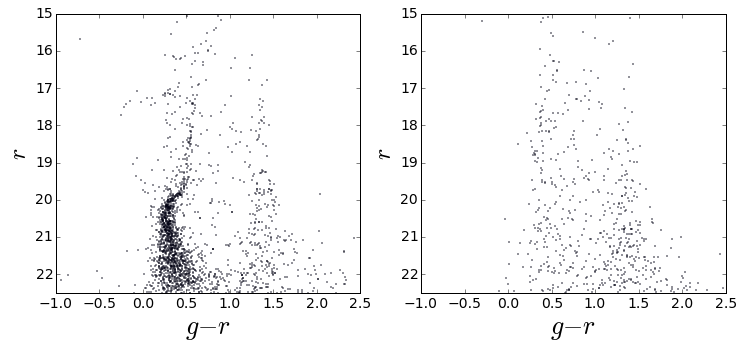

In [59]:
fig, ax = plt.subplots(ncols=2, figsize=(12, 5))
add_cmd(ax[0], pal5)
add_cmd(ax[1], sky)

* Identify a region in $g−r$ vs $g$ plot where the difference between the two plots appears greatest. From your original sample, select stars only present in that color-magnitude box, and plot them in ra vs dec scatter plot. Do you notice anything interesting?

In [55]:
gr = pd.read_sql("""SELECT ra, dec, dered_g, dered_r FROM field 
    WHERE dered_g > 18.8 and dered_g < 22 and 
    dered_g-dered_r > 0 and dered_g-dered_r < .5""", db)

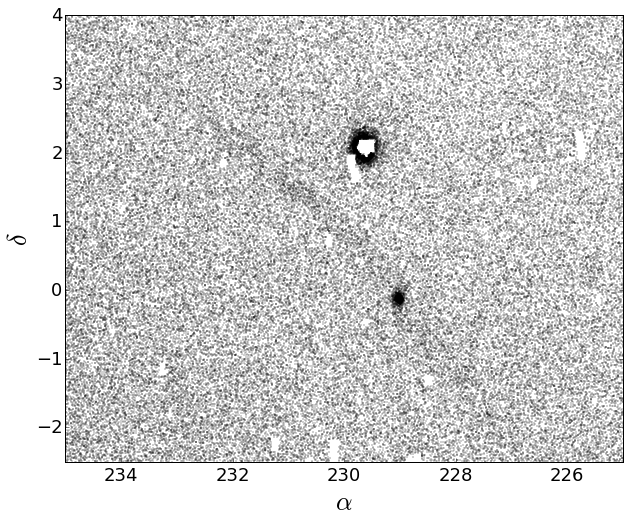

In [60]:
plt.figure(figsize=(10,8))
plt.scatter(gr['ra'], gr['dec'],s=.05,color='k')
plt.xlim(235, 225)
plt.ylim(-2.5,4)
plt.xlabel(r'$\alpha$',fontsize=26)
plt.ylabel(r'$\delta$',fontsize=26)
plt.tick_params(axis='both', which='major', labelsize=18)

#plt.axhline(y=-.25,color='white')
#plt.axhline(y=0,color='white')

plt.show()

<b> The tidal stream is more apparent! We isolated the region in the color-color diagram where stars of a single population (age) are most easily identified so we can see the tails of the tidally disrupted globular cluster.</b>

* Extra credit: how would you make the determination of the $g−r$ vs $g$ selection box more quantitative?

<b> We could make the determination of the selection box more quantitative by consulting Zeljko's book on Statistics, Data Mining and Machine Learning, i.e. we could use a Gaussian mixture model and extreme deconvolution to identify substructure in the color-color plots (this is often done to identify RR Lyrae stars). We could also employ photometric distances or proper motion cuts as additional criteria for selecting members of the Palomar 5 globular cluster. </b>

## Problem 2: Importing data into the Large Survey Database


* Read about the [data contained in sweep files](http://dr12.sdss3.org/datamodel/files/PHOTO_SWEEP/RERUN/calibObj.html) for stars. Write a corresponding YAML LSD schema file. Make sure it consists of (at least) four tablets: basic quantities, photometry, image, resolve and calibration quantities, and the 2MASS match information. Create an LSD table with that schema.


<b> Note! These LSD commands can only be run from magneto or astro linux machines.</b>

In [11]:
import os
os.environ['NWORKERS'] = '8'
os.environ['LSD_CACHEDIR'] = os.environ['HOME'] + '/tempdir'
os.environ['LSD_TEMPDIR'] = os.environ['HOME'] + '/tempdir'
os.environ['LSD_DB'] = os.environ['HOME']+'/lsddb:/astro/apps6/opt/lsddb'

In [12]:
from lsd import DB
from lsd.bounds import beam, rectangle

In [16]:
!  cat run94.yaml

# Schema for SDSS table (run94)
filters: {complevel: 5, complib: blosc}
schema:
  common:
    primary_key: ID
    spatial_keys: [RA, DEC]
    columns:
    - [RUN, u2] 
    - [RERUN, S3] 
    - [CAMCOL, u1] 
    - [FIELD, i2] 
    - [ID, u8] 
    - [OBJC_TYPE, i4] 
    - [OBJC_FLAGS, i4] 
    - [OBJC_FLAGS2, i4] 
    - [ZHEDFLAG, i2] 
    - [OBJC_ROWC, f4] 
    - [ROWVDEG, f4] 
    - [ROWVDEGERR, f4] 
    - [ROWC, 5f4] 
    - [COLVDEG, f4] 
    - [COLVDEGERR, f4] 
    - [COLC, 5f4] 
    - [FLAGS, 5i4] 
    - [FLAGS2, 5i4] 
    - [RA, f8] 
    - [DEC, f8] 
  phot:
    columns:
    - [SKYFLUX, 5f4] 
    - [PSFFLUX, 5f4] 
    - [PSFFLUX_IVAR, 5f4] 
    - [MODELFLUX, 5f4] 
    - [MODELFLUX_IVAR, 5f4] 
    - [EXTINCTION, 5f4] 
    - [APERFLUX6, 5f4] 
  calib:
    columns:
    - [PSP_STATUS, 5i4] 
    - [PSF_FWHM, 5f4] 
    - [RESOLVE_STATUS, i4] 
    - [THING_ID, i4] 
    - [IFIELD, i4] 
    - [BALKAN_ID, i4] 
    - [NDETECT, i4] 
    - [CALIB_STATUS, 5i4] 
    - [NMGYPERCOUNT, 5f4] 
  2mass

In [17]:
! lsd-admin create table --schema run94.yaml run94 --drop-existing

Table 'run94' dropped.

-------- committing 20160226034836.304869 [run94] ---------
[run94] Updating tablet catalog: [256 el.]::::::::::::::::::::>  0.24 sec
[run94] Updating neighbors: Already up to date.
[run94] Updating tablet catalog: [256 el.]::::::::::::::::::::>  0.21 sec
[run94] Updating stats: [0 el.]>  0.00 sec
[run94] Marking tablets read-only...
----------- success 20160226034836.304869 [run94] ---------

Table 'run94' created.


* Download all files belonging to run 94, from http://data.sdss3.org/sas/dr12/boss/sweeps/dr9/301/. Use `lsd-import` to import these files.

In [35]:
print os.getcwd()

/astro/users/kweis/Desktop/astr597_klw


In [34]:
! lsd-import fits run94 /astro/users/kweis/Desktop/astr597_klw/sdssdata/calibObj-000094-*-star.fits

Importing from 6 pieces:
  ===> Imported ...sers/kweis/Desktop/astr597_klw/sdssdata/calibObj-000094-4-star.fits [1/6, 16.67%] + 130027/130027     130027 (0/2 min.)
  ===> Imported ...sers/kweis/Desktop/astr597_klw/sdssdata/calibObj-000094-1-star.fits [2/6, 33.33%] + 133515/133515     263542 (0/1 min.)
  ===> Imported ...sers/kweis/Desktop/astr597_klw/sdssdata/calibObj-000094-6-star.fits [3/6, 50.00%] + 138113/138113     401655 (0/1 min.)
  ===> Imported ...sers/kweis/Desktop/astr597_klw/sdssdata/calibObj-000094-5-star.fits [4/6, 66.67%] + 136292/136292     537947 (0/0 min.)
  ===> Imported ...sers/kweis/Desktop/astr597_klw/sdssdata/calibObj-000094-2-star.fits [5/6, 83.33%] + 155355/155355     693302 (0/0 min.)
  ===> Imported ...sers/kweis/Desktop/astr597_klw/sdssdata/calibObj-000094-3-star.fits [6/6, 100.00%] + 124832/124832     818134 (0/0 min.)
done

-------- committing 20160226035353.960813 [run94] ---------
[run94] Updating tablet catalog: [256 el.]::::::::::::::::::::>  0.35 sec


* Use `lsd-footprint` to compute the footprint of the run, and plot the result.

In [50]:
! lsd-footprint run94 run94.fits
# could also do with --resolution =20 to change res of footprint

 [48 el.]::::::::::::::::::::>  2.73 sec
Objects: 818134.0


In [53]:
from astropy.io import fits
fp=fits.getdata('run94.fits')
fp[fp==0] = np.nan

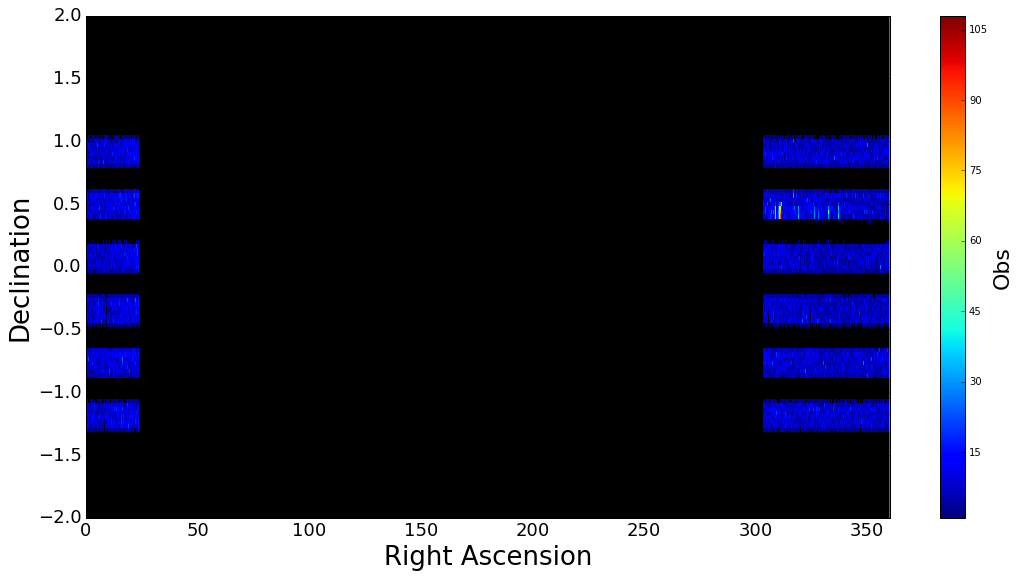

In [58]:
fig, ax = plt.subplots(figsize=(18,9)) 
cmap = plt.cm.jet 
cmap.set_bad('black') 
fp_plt = ax.imshow(np.rot90(fp.T, 1), extent=(0, 360, 90, -90), 
                   interpolation='none',aspect='auto',cmap=cmap) 
ax.set_xlabel('Right Ascension',fontsize=26)
ax.set_ylabel('Declination',fontsize=26)
ax.set_ylim(-2,2) 
cbar = fig.colorbar(fp_plt)
cbar.ax.set_ylabel('Obs', fontsize=22) 
ax.tick_params(labelsize=18)
plt.show()